In [9]:
import subprocess
from pathlib import Path

# ---------- Config ----------
BASE_DIR = Path("/home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_Thesis_Repo")
TEST_PATH = BASE_DIR / "Corpus/test/lv_lvtb-ud-test.spacy"

MODELS = [
    "lv_spacy_cnn_1pct",
    "lv_spacy_cnn_5pct",
    "lv_spacy_cnn_20pct",
    "lv_spacy_cnn_50pct",
    "lv_spacy_cnn_100pct",
    "lv_roberta_base_1pct",
    "lv_roberta_base_5pct",
    "lv_roberta_base_20pct",
    "lv_roberta_base_50pct",
    "lv_roberta_base_100pct",
    "lv_roberta_large_1pct",
    "lv_roberta_large_5pct",
    "lv_roberta_large_20pct",
    "lv_roberta_large_50pct",
    "lv_roberta_large_100pct",
]

JSON_DIR = BASE_DIR / "Summary_JSONs"
JSON_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Run CLI to generate JSON ----------
for model_name in MODELS:
    print(f"\n🔹 Generating JSON for {model_name} ...")
    json_path = JSON_DIR / f"{model_name}.json"

    cmd = [
        "python", "-m", "spacy", "evaluate",
        model_name,
        str(TEST_PATH),
        "--output", str(json_path),
        "--gpu-id", "0"  # 可改为 None 如果不使用 GPU
    ]

    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"⚠️ spacy evaluate failed for {model_name}:", result.stderr)
    else:
        print(f"✅ JSON saved to {json_path}")



🔹 Generating JSON for lv_spacy_cnn_1pct ...
✅ JSON saved to /home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_Thesis_Repo/Summary_JSONs/lv_spacy_cnn_1pct.json

🔹 Generating JSON for lv_spacy_cnn_5pct ...
✅ JSON saved to /home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_Thesis_Repo/Summary_JSONs/lv_spacy_cnn_5pct.json

🔹 Generating JSON for lv_spacy_cnn_20pct ...
✅ JSON saved to /home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_Thesis_Repo/Summary_JSONs/lv_spacy_cnn_20pct.json

🔹 Generating JSON for lv_spacy_cnn_50pct ...
✅ JSON saved to /home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_Thesis_Repo/Summary_JSONs/lv_spacy_cnn_50pct.json

🔹 Generating JSON for lv_spacy_cnn_100pct ...
✅ JSON saved to /home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_Thesis_Repo/Summary_JSONs/lv_spacy_cnn_100pct.json

🔹 Generating JSON for lv_roberta_base_1pct ...
✅ JSON saved to /home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_

In [10]:
import json
import pandas as pd
from pathlib import Path

# ---------- Config ----------
BASE_DIR = Path("/home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_Thesis_Repo")
JSON_DIR = BASE_DIR / "Summary_JSONs"
OUT_DIR = BASE_DIR / "Summary_CSVs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 模型列表
MODELS = [
    "lv_spacy_cnn_1pct",
    "lv_spacy_cnn_5pct",
    "lv_spacy_cnn_20pct",
    "lv_spacy_cnn_50pct",
    "lv_spacy_cnn_100pct",
    "lv_roberta_base_1pct",
    "lv_roberta_base_5pct",
    "lv_roberta_base_20pct",
    "lv_roberta_base_50pct",
    "lv_roberta_base_100pct",
    "lv_roberta_large_1pct",
    "lv_roberta_large_5pct",
    "lv_roberta_large_20pct",
    "lv_roberta_large_50pct",
    "lv_roberta_large_100pct",
]

# 用来保存三类数据
basic_rows = []
morph_rows = []
las_rows = []

# ---------- 遍历 JSON ----------
for model_name in MODELS:
    json_path = JSON_DIR / f"{model_name}.json"
    if not json_path.exists():
        print(f"⚠️ JSON not found for {model_name}, skipping...")
        continue

    with open(json_path, "r") as f:
        data = json.load(f)

    # --- 1. Basic metrics ---
    basic_rows.append({
        "model": model_name,
        "token_acc": data.get("token_acc"),
        "pos_acc": data.get("pos_acc"),
        "morph_f": data.get("morph_micro_f") or data.get("morph_f"),
        "lemma_acc": data.get("lemma_acc"),
        "dep_las": data.get("dep_las"),
        "sents_f": data.get("sents_f")
    })

    # --- 2. Morph per feature ---
    morph_data = data.get("morph_per_feat", {})
    for feat, scores in morph_data.items():
        morph_rows.append({
            "model": model_name,
            "feature": feat,
            "p": scores.get("p"),
            "r": scores.get("r"),
            "f": scores.get("f")
        })

    # --- 3. LAS per type ---
    las_data = data.get("dep_las_per_type", {})
    for dep, scores in las_data.items():
        las_rows.append({
            "model": model_name,
            "dep_type": dep,
            "p": scores.get("p"),
            "r": scores.get("r"),
            "f": scores.get("f")
        })

# ---------- 保存 CSV ----------
pd.DataFrame(basic_rows).to_csv(OUT_DIR / "evaluation_basic_metrics.csv", index=False)
pd.DataFrame(morph_rows).to_csv(OUT_DIR / "evaluation_morph_per_feat.csv", index=False)
pd.DataFrame(las_rows).to_csv(OUT_DIR /"evaluation_dep_las_per_type.csv", index=False)

print("\n✅ All three CSV files saved in Summary_CSVs!")



✅ All three CSV files saved in Summary_CSVs!


In [11]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from pathlib import Path
import pandas as pd

# ---------- Config ----------
BASE_DIR = Path(".") 
BASE_DIR = Path("/home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_Thesis_Repo")

TEST_PATH = BASE_DIR / "Corpus/test/lv_lvtb-ud-test.spacy"

MODELS = [
    ("lv_spacy_cnn_1pct",  "CNN", 1),
    ("lv_spacy_cnn_5pct",  "CNN", 5),
    ("lv_spacy_cnn_20pct", "CNN", 20),
    ("lv_spacy_cnn_50pct", "CNN", 50),
    ("lv_spacy_cnn_100pct","CNN",100),
    ("lv_roberta_base_1pct",  "XLM-R-base", 1),
    ("lv_roberta_base_5pct",  "XLM-R-base", 5),
    ("lv_roberta_base_20pct", "XLM-R-base",20),
    ("lv_roberta_base_50pct", "XLM-R-base",50),
    ("lv_roberta_base_100pct","XLM-R-base",100),
    ("lv_roberta_large_1pct",  "XLM-R-large", 1),
    ("lv_roberta_large_5pct",  "XLM-R-large", 5),
    ("lv_roberta_large_20pct", "XLM-R-large",20),
    ("lv_roberta_large_50pct", "XLM-R-large",50),
    ("lv_roberta_large_100pct","XLM-R-large",100),
]

# ---------- Output ----------
OUT_DIR = BASE_DIR / "Summary_CSVs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Load test docs ----------
print("Loading test docs...")
test_docbin = DocBin().from_disk(TEST_PATH)
# 必须提供 vocab，否则会报 TypeError（你之前的错误）
# 可以用空白模型的 vocab 来 decode DocBin
temp_nlp = spacy.blank("lv")
gold_docs = list(test_docbin.get_docs(temp_nlp.vocab))

print(f"🔎 Loaded {len(gold_docs)} test sentences")

oov_rows = []

# ---------- Run OOV evaluation ----------
for model_name, model_type, pct in MODELS:

    print(f"\n🔹 Evaluating {model_name} (train = {pct}%)")

    # ---- load model ----
    try:
        nlp = spacy.load(model_name)
    except Exception as e:
        print(f"Failed to load {model_name}: {e}")
        continue

    # ---- load train vocab ----
    train_path = BASE_DIR / f"Corpus/train/lv_lvtb-ud-train-{pct}pct.spacy"
    if not train_path.exists():
        print(f"⚠️ Training file missing: {train_path}")
        continue

    train_docbin = DocBin().from_disk(train_path)
    train_vocab = set()

    for doc in train_docbin.get_docs(nlp.vocab):
        for token in doc:
            train_vocab.add(token.text)

    # ---- predict ----
    preds = list(nlp.pipe([doc.text for doc in gold_docs], batch_size=32))

    # ---- metrics data structure ----
    metrics = {
        k: {"iv_total": 0, "iv_correct": 0, "oov_total": 0, "oov_correct": 0}
        for k in ["POS", "MORPH", "LEMMA", "UAS", "LAS"]
    }

    # ---- compute OOV/IV ----
    for gold_doc, pred_doc in zip(gold_docs, preds):
        for g, p in zip(gold_doc, pred_doc):

            is_iv = g.text in train_vocab

            # POS ----------
            correct_pos = (g.pos_ == p.pos_)
            group = "iv" if is_iv else "oov"
            metrics["POS"][f"{group}_total"] += 1
            if correct_pos:
                metrics["POS"][f"{group}_correct"] += 1

            # MORPH (exact match dict) ----------
            correct_morph = (g.morph.to_dict() == p.morph.to_dict())
            metrics["MORPH"][f"{group}_total"] += 1
            if correct_morph:
                metrics["MORPH"][f"{group}_correct"] += 1

            # LEMMA ----------
            correct_lemma = (g.lemma_ == p.lemma_)
            metrics["LEMMA"][f"{group}_total"] += 1
            if correct_lemma:
                metrics["LEMMA"][f"{group}_correct"] += 1

            # PARSE ----------
            if g.head is not None:

                correct_uas = (g.head.i == p.head.i)
                correct_las = correct_uas and (g.dep_ == p.dep_)

                # UAS
                metrics["UAS"][f"{group}_total"] += 1
                if correct_uas:
                    metrics["UAS"][f"{group}_correct"] += 1

                # LAS
                metrics["LAS"][f"{group}_total"] += 1
                if correct_las:
                    metrics["LAS"][f"{group}_correct"] += 1

    # ---- save metrics per component ----
    for comp, m in metrics.items():
        iv_acc = (m["iv_correct"] / m["iv_total"] * 100) if m["iv_total"] else None
        oov_acc = (m["oov_correct"] / m["oov_total"] * 100) if m["oov_total"] else None

        oov_rows.append({
            "model": model_name,
            "framework": model_type,
            "data_pct": pct,
            "component": comp,
            "IV_acc": iv_acc,
            "OOV_acc": oov_acc,
            "IV_total": m["iv_total"],
            "OOV_total": m["oov_total"]
        })

# ---------- Save CSV ----------
df_oov = pd.DataFrame(oov_rows)
df_oov.to_csv(OUT_DIR / "oov_iv_summary.csv", index=False)

print("\n✅ Saved Summary_CSVs/oov_iv_summary.csv")


Loading test docs...
🔎 Loaded 2412 test sentences

🔹 Evaluating lv_spacy_cnn_1pct (train = 1%)

🔹 Evaluating lv_spacy_cnn_5pct (train = 5%)

🔹 Evaluating lv_spacy_cnn_20pct (train = 20%)

🔹 Evaluating lv_spacy_cnn_50pct (train = 50%)

🔹 Evaluating lv_spacy_cnn_100pct (train = 100%)

🔹 Evaluating lv_roberta_base_1pct (train = 1%)

🔹 Evaluating lv_roberta_base_5pct (train = 5%)

🔹 Evaluating lv_roberta_base_20pct (train = 20%)

🔹 Evaluating lv_roberta_base_50pct (train = 50%)

🔹 Evaluating lv_roberta_base_100pct (train = 100%)

🔹 Evaluating lv_roberta_large_1pct (train = 1%)

🔹 Evaluating lv_roberta_large_5pct (train = 5%)

🔹 Evaluating lv_roberta_large_20pct (train = 20%)

🔹 Evaluating lv_roberta_large_50pct (train = 50%)

🔹 Evaluating lv_roberta_large_100pct (train = 100%)

✅ Saved Summary_CSVs/oov_iv_summary.csv


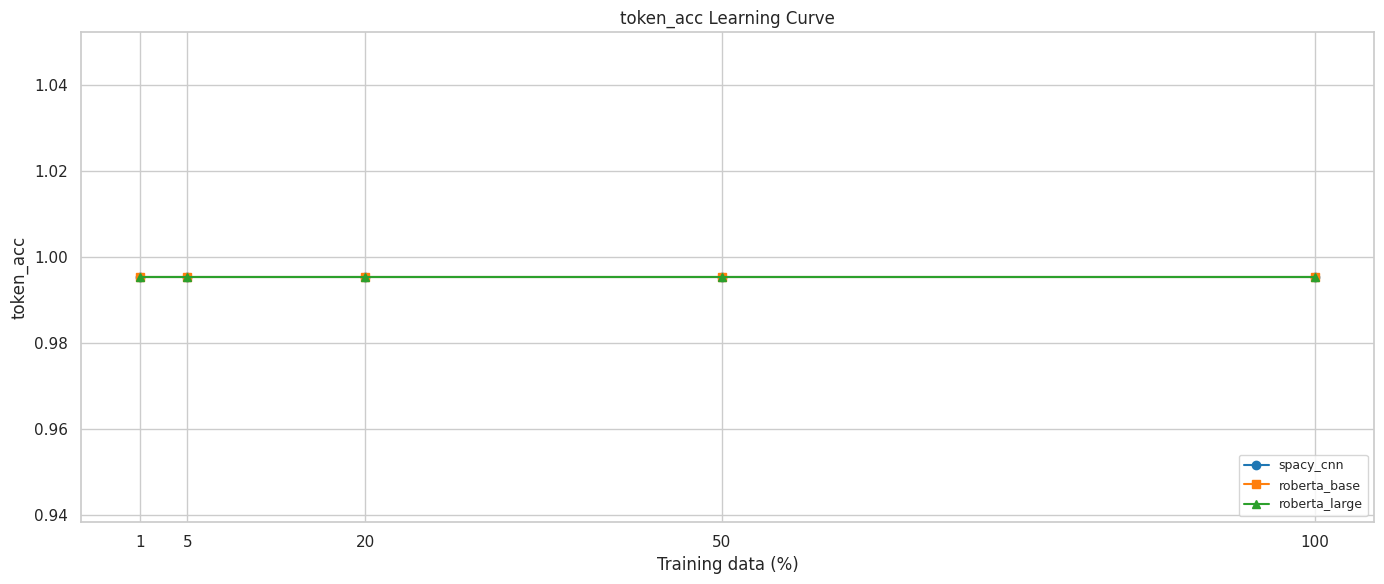

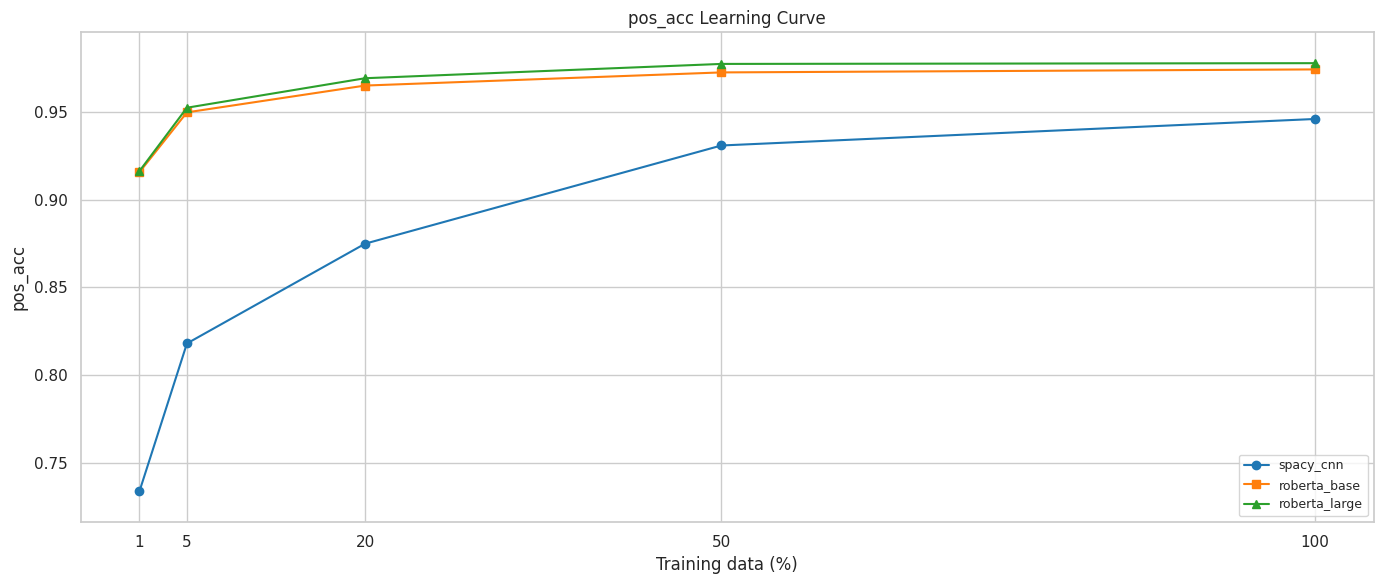

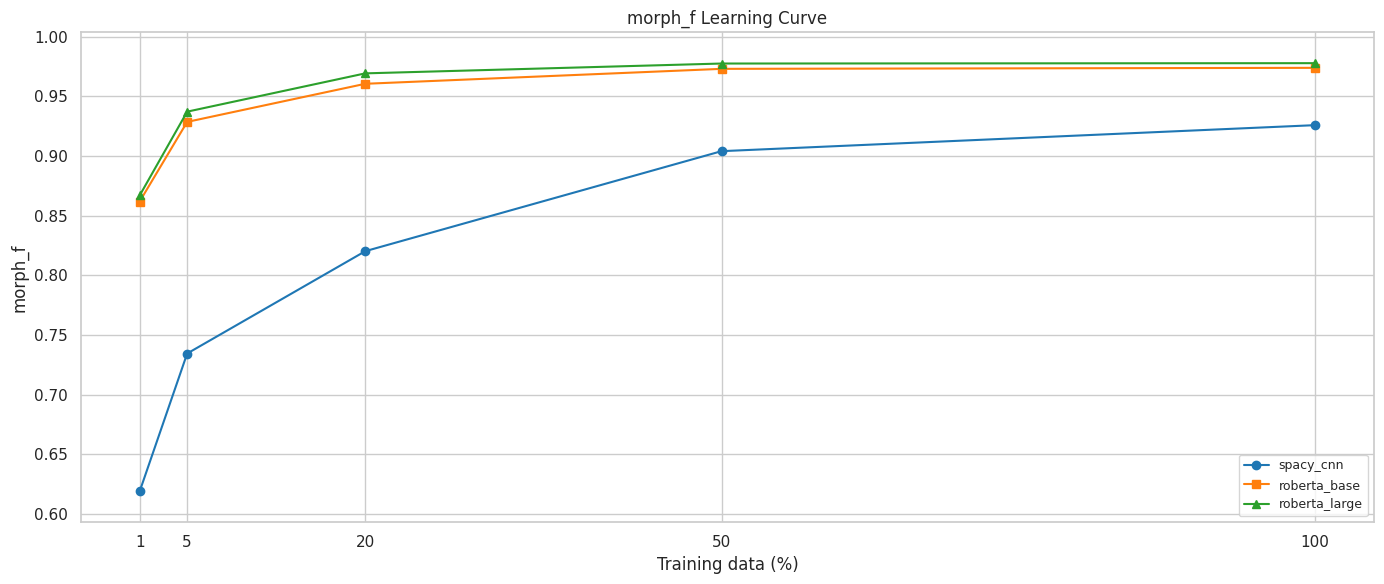

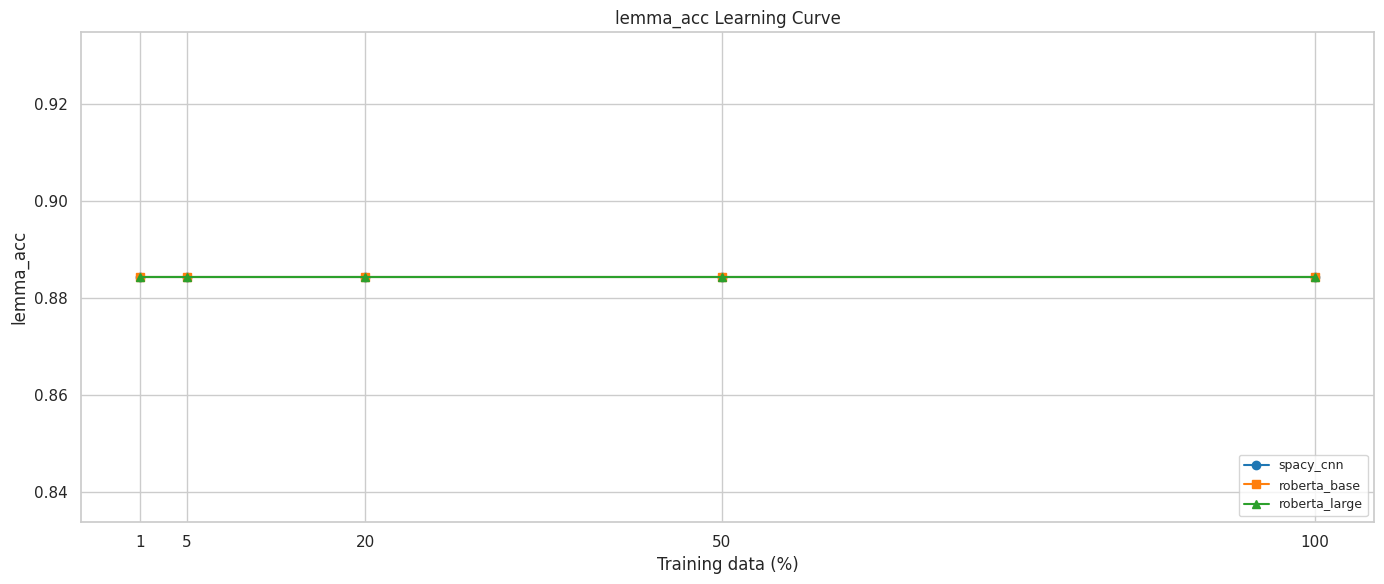

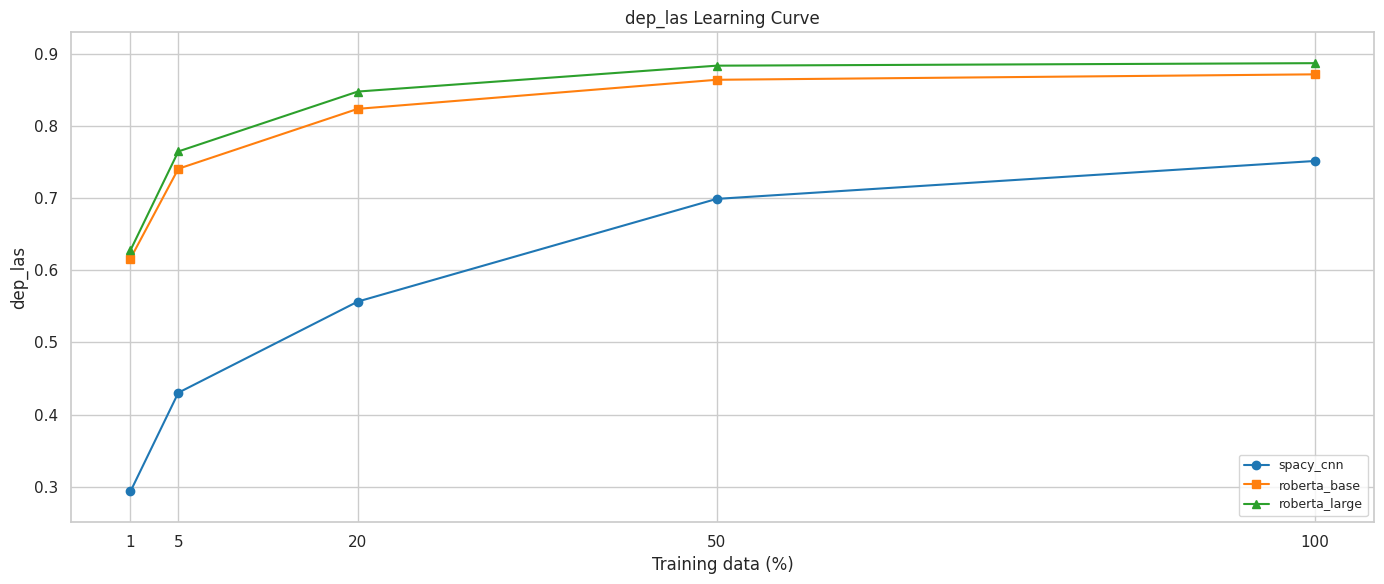

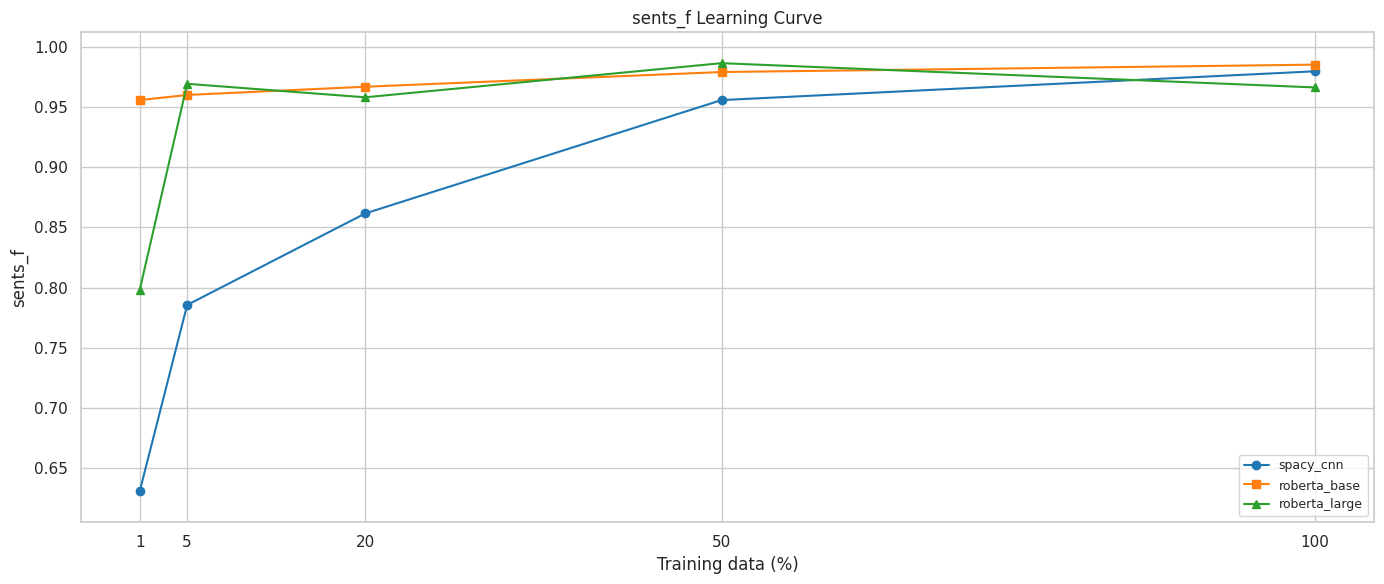

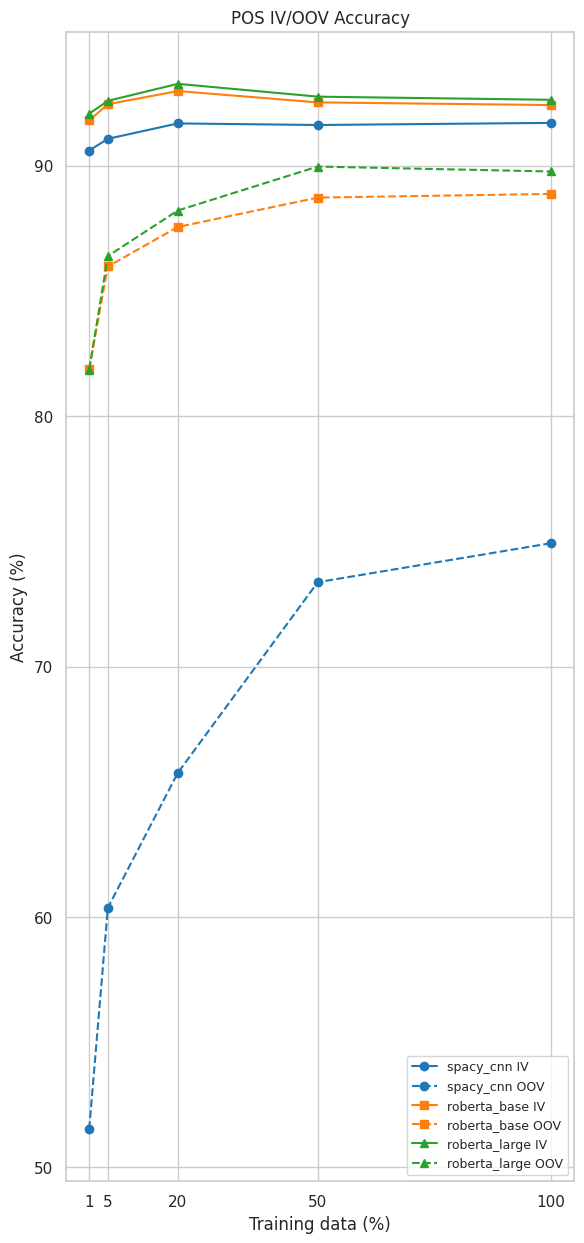

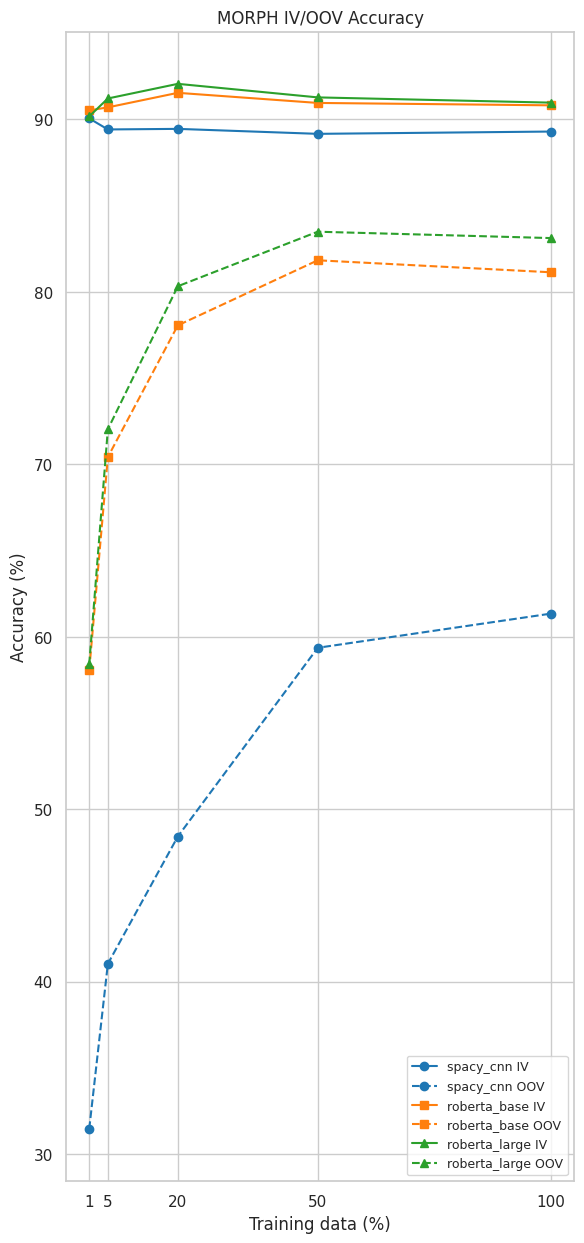

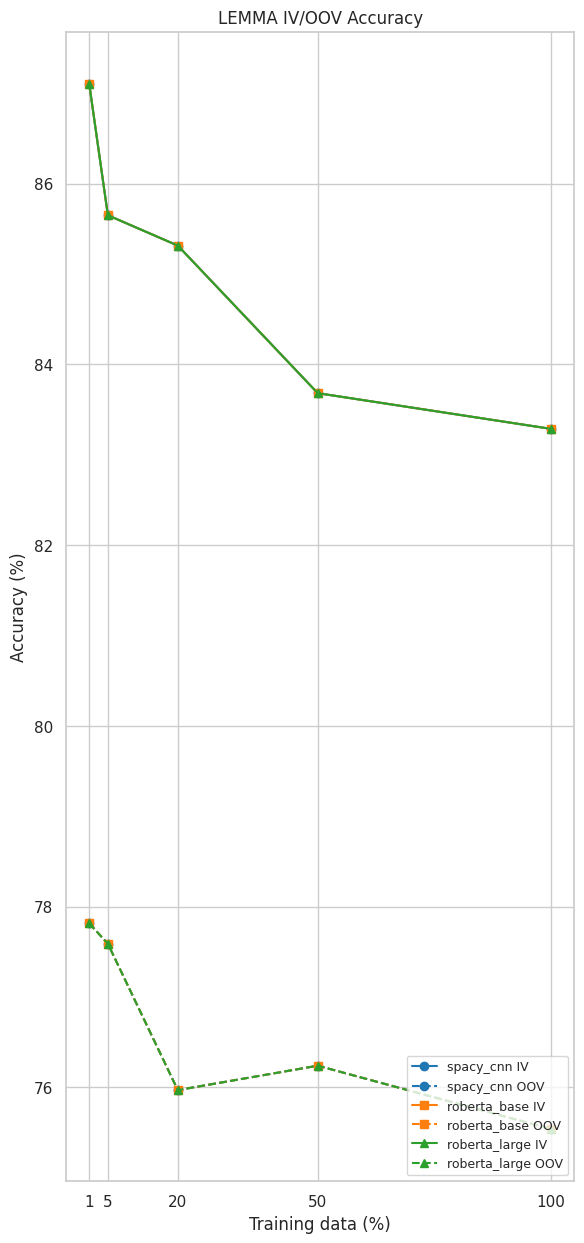

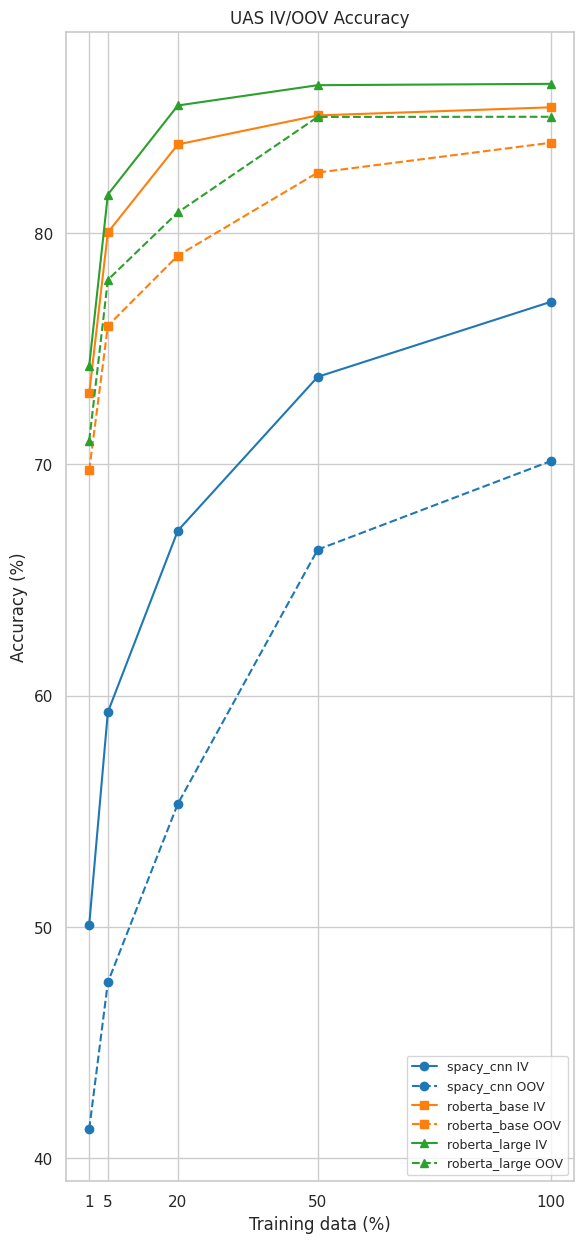

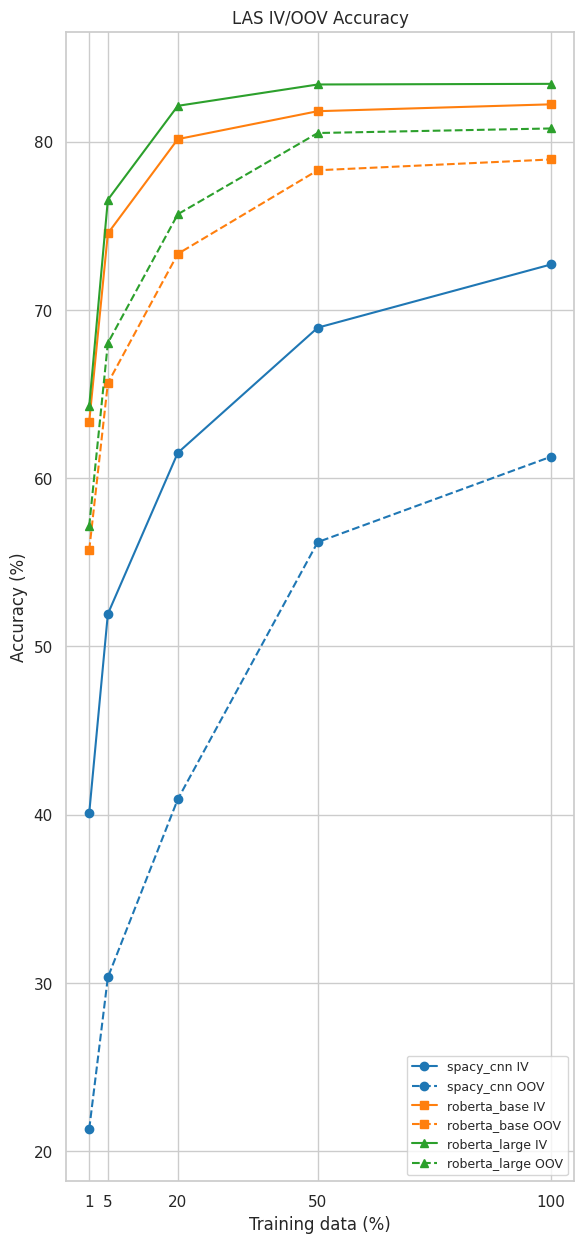

In [61]:
# === 可视化学习曲线和 OOV/IV（不抖动版）===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ---------- 1️⃣ Load CSVs ----------
df_eval = pd.read_csv("./Summary_CSVs/evaluation_basic_metrics.csv")
df_oov  = pd.read_csv("./Summary_CSVs/oov_iv_summary.csv")

# ---------- 2️⃣ 从 model 列提取 framework 和 data_pct ----------
df_eval['data_pct'] = df_eval['model'].apply(lambda x: int(x.split('_')[-1].replace('pct','')))
df_eval['framework'] = df_eval['model'].apply(lambda x: '_'.join(x.split('_')[1:-1]))

df_oov['data_pct'] = df_oov['model'].apply(lambda x: int(x.split('_')[-1].replace('pct','')))
df_oov['framework'] = df_oov['model'].apply(lambda x: '_'.join(x.split('_')[1:-1]))

# ---------- 3️⃣ 学习曲线 ----------
metrics = ['token_acc', 'pos_acc', 'morph_f', 'lemma_acc', 'dep_las', 'sents_f']
x_order = [1, 5, 20, 50, 100]

markers = ["o", "s", "^", "D", "v", "*"]  # 不同 marker
linestyles = ["-", "--", "-.", ":"]        # 不同 linestyle
colors = sns.color_palette("tab10")         # 10 种颜色

for metric in metrics:
    plt.figure(figsize=(14,6)) 
    for i, framework in enumerate(df_eval["framework"].unique()):
        sub = df_eval[df_eval["framework"] == framework].copy()
        sub = sub.set_index("data_pct").reindex(x_order).reset_index()

        plt.plot(sub["data_pct"], sub[metric], 
                 marker=markers[i % len(markers)],
                 linestyle="-",
                 color=colors[i % len(colors)],
                 label=framework)

    plt.title(f"{metric} Learning Curve")
    plt.xlabel("Training data (%)")
    plt.ylabel(metric)
    plt.xticks(x_order)
    
    # 上下留白
    ymin, ymax = plt.ylim()
    plt.ylim(ymin - 0.02*(ymax-ymin), ymax + 0.02*(ymax-ymin))
    
    # 图例右下角
    plt.legend(loc='lower right', fontsize=9)
    plt.tight_layout()
    plt.show()

# ---------- 4️⃣ OOV/IV 对比（优化图例+纵向比例+压缩底部）----------
components = df_oov["component"].unique()

for comp in components:
    plt.figure(figsize=(6,14))  
    sub = df_oov[df_oov["component"] == comp]
    for i, framework in enumerate(sub["framework"].unique()):
        sub_fw = sub[sub["framework"] == framework]
        # IV accuracy
        plt.plot(sub_fw["data_pct"], sub_fw["IV_acc"], 
                 marker=markers[i % len(markers)], linestyle="-",
                 color=colors[i % len(colors)],
                 label=f"{framework} IV")
        # OOV accuracy
        plt.plot(sub_fw["data_pct"], sub_fw["OOV_acc"], 
                 marker=markers[i % len(markers)], linestyle="--",
                 color=colors[i % len(colors)],
                 label=f"{framework} OOV")
    
    plt.title(f"{comp} IV/OOV Accuracy")
    plt.xlabel("Training data (%)")
    plt.ylabel("Accuracy (%)")
    plt.xticks(x_order)
    
    # 自适应纵向范围，压缩上下空白
    all_values = sub[["IV_acc","OOV_acc"]].values.flatten()
    ymin, ymax = all_values.min(), all_values.max()
    ypad = (ymax - ymin) * 0.05  # 上下各留 5% 空白
    plt.ylim(max(0, ymin - ypad), min(100, ymax + ypad))
    
    # 图例右下角
    plt.legend(loc='lower right', fontsize=9)
    
    # 压缩底部和整体布局
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # ↓ 底部空白
    plt.show()


/tmp/ipykernel_5906/760651575.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


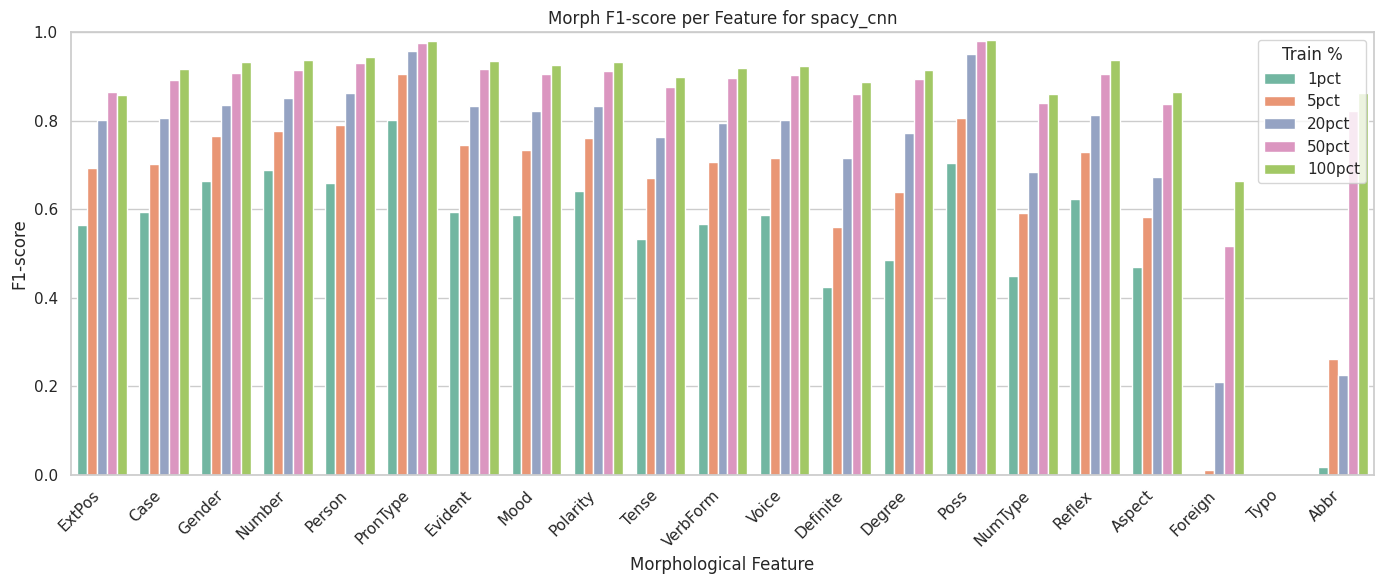

/tmp/ipykernel_5906/760651575.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


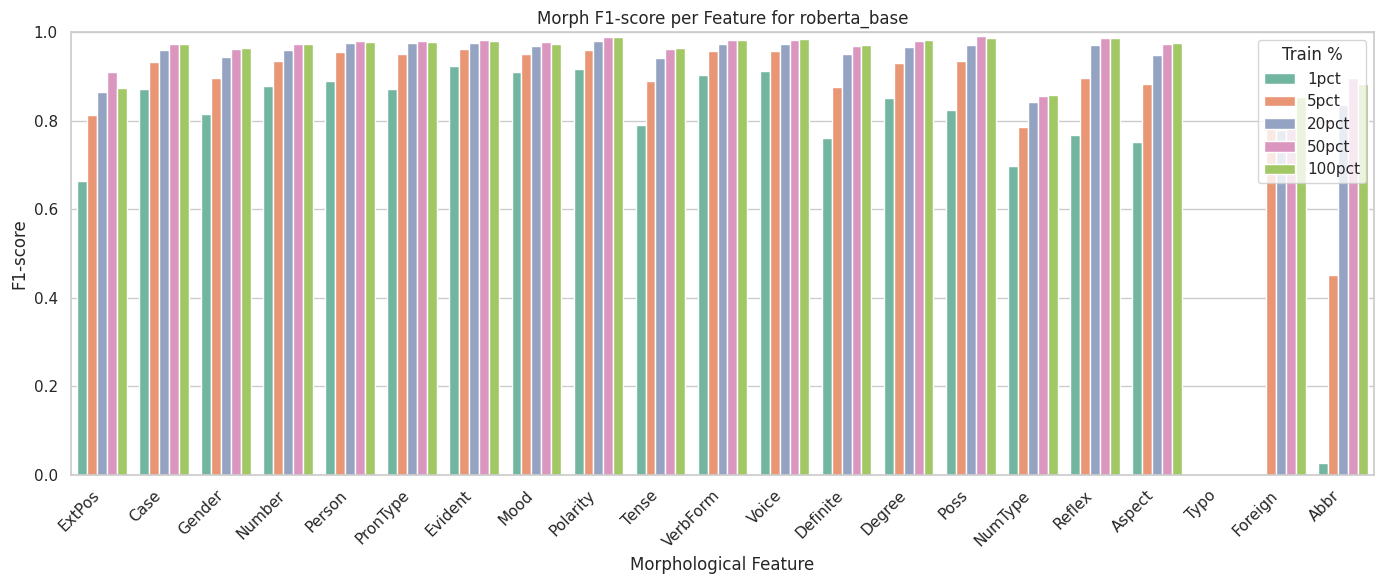

/tmp/ipykernel_5906/760651575.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


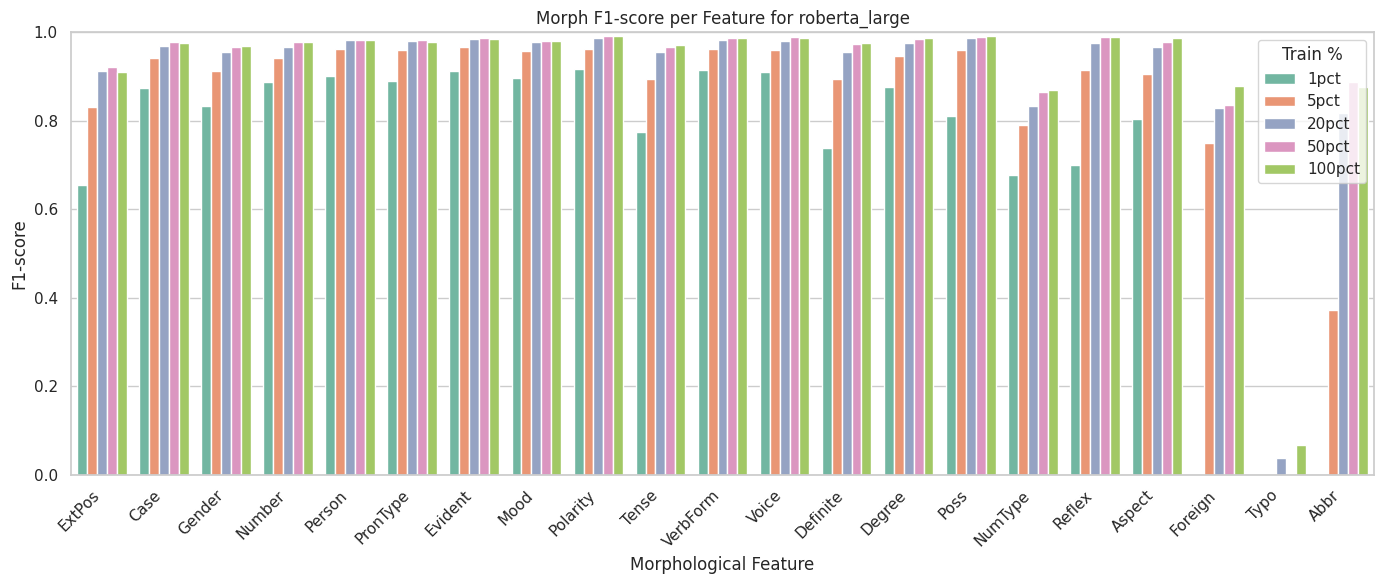

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取 CSV
file_path = './Summary_CSVs/evaluation_morph_per_feat.csv'
df = pd.read_csv(file_path)

# 提取模型和训练比例
df[['Language', 'Model', 'TrainPct']] = df['model'].str.extract(r'(lv)_(\w+_\w+|spacy_cnn)_(\d+pct)')

# 获取所有模型列表
models = df['Model'].unique()

# 对每个模型绘制单独柱状图
for model in models:
    df_model = df[df['Model'] == model]
    
    plt.figure(figsize=(14, 6))
    sns.barplot(
        data=df_model,
        x='feature',
        y='f',
        hue='TrainPct',
        ci=None,
        palette='Set2'
    )
    
    plt.title(f"Morph F1-score per Feature for {model}")
    plt.ylabel("F1-score")
    plt.xlabel("Morphological Feature")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.legend(title='Train %')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_5906/3787461403.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index='feature', columns='Model_Train', values='f')


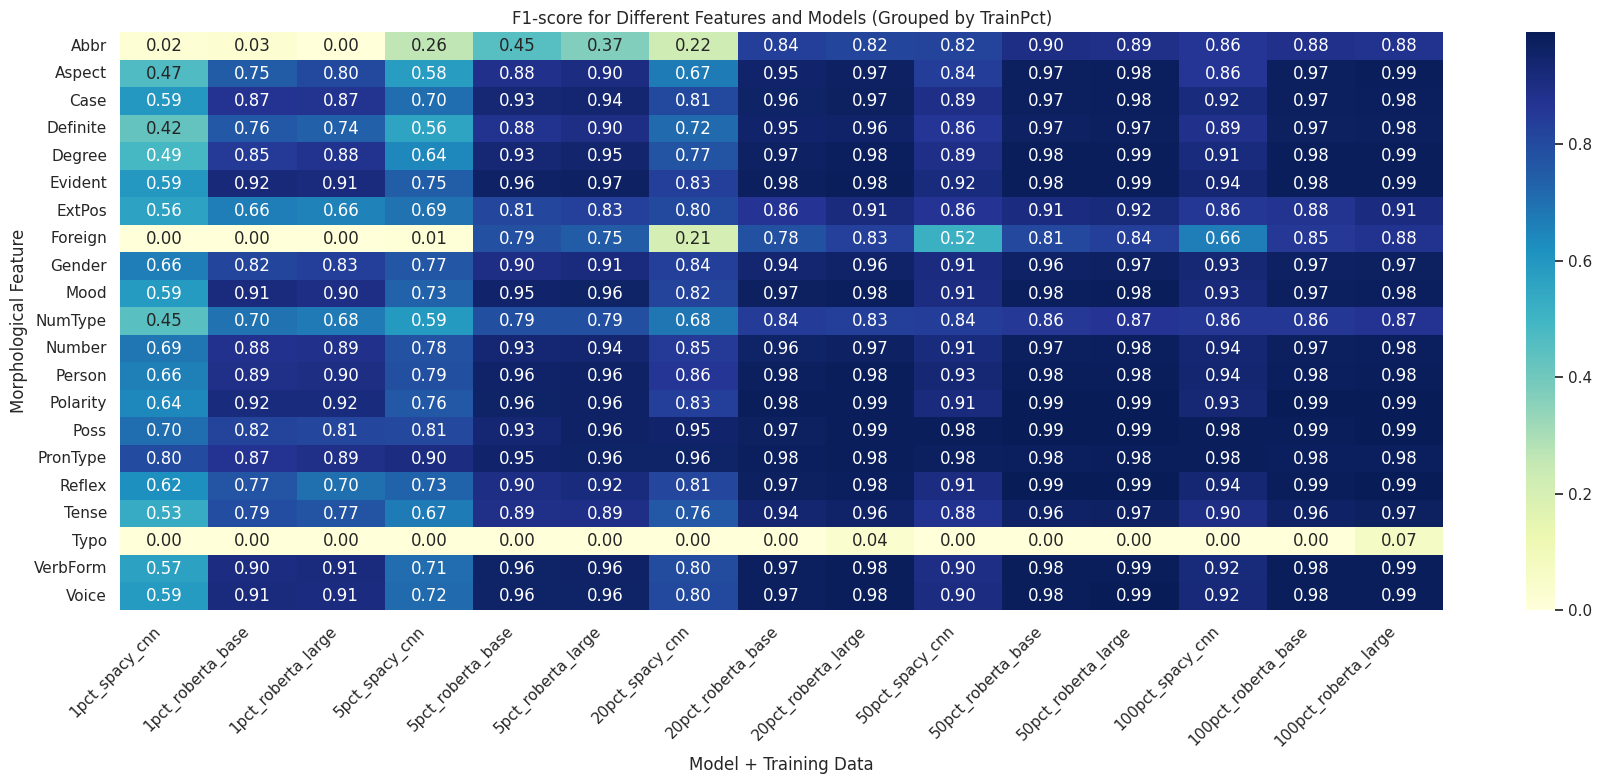

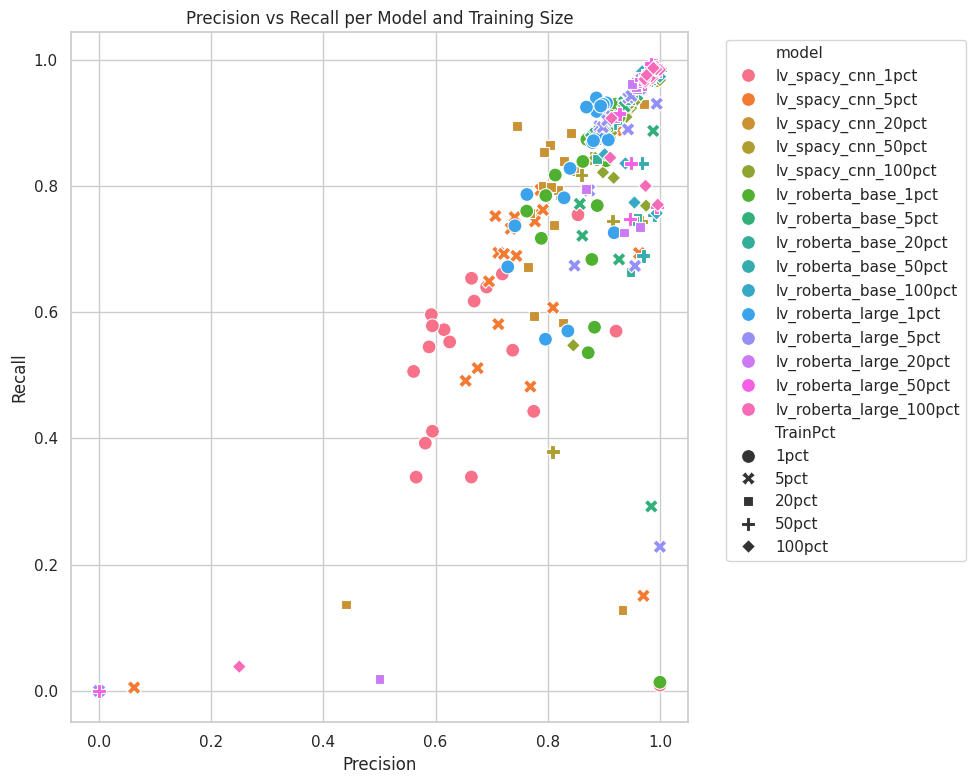

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取 CSV
df = pd.read_csv('./Summary_CSVs/evaluation_morph_per_feat.csv')
df[['Language', 'Model', 'TrainPct']] = df['model'].str.extract(r'(lv)_(\w+_\w+|spacy_cnn)_(\d+pct)')

# 定义顺序
train_order = ['1pct', '5pct', '20pct', '50pct', '100pct']
model_order = ['spacy_cnn', 'roberta_base', 'roberta_large']

# 分类列
df['TrainPct'] = pd.Categorical(df['TrainPct'], categories=train_order, ordered=True)
df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)

# 创建排序列
df['Model_Train'] = df['TrainPct'].astype(str) + '_' + df['Model'].astype(str)


# 创建 Model_Train 的完整顺序
model_train_order = [t + '_' + m for t in train_order for m in model_order]
df['Model_Train'] = pd.Categorical(df['Model_Train'], categories=model_train_order, ordered=True)

# pivot table
pivot_table = df.pivot_table(index='feature', columns='Model_Train', values='f')

# 绘制热力图
plt.figure(figsize=(18, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("F1-score for Different Features and Models (Grouped by TrainPct)")
plt.ylabel("Morphological Feature")
plt.xlabel("Model + Training Data")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6️⃣ 可选：Precision vs Recall 散点图
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='p',
    y='r',
    hue='model',
    style='TrainPct',
    s=100
)
plt.title("Precision vs Recall per Model and Training Size")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



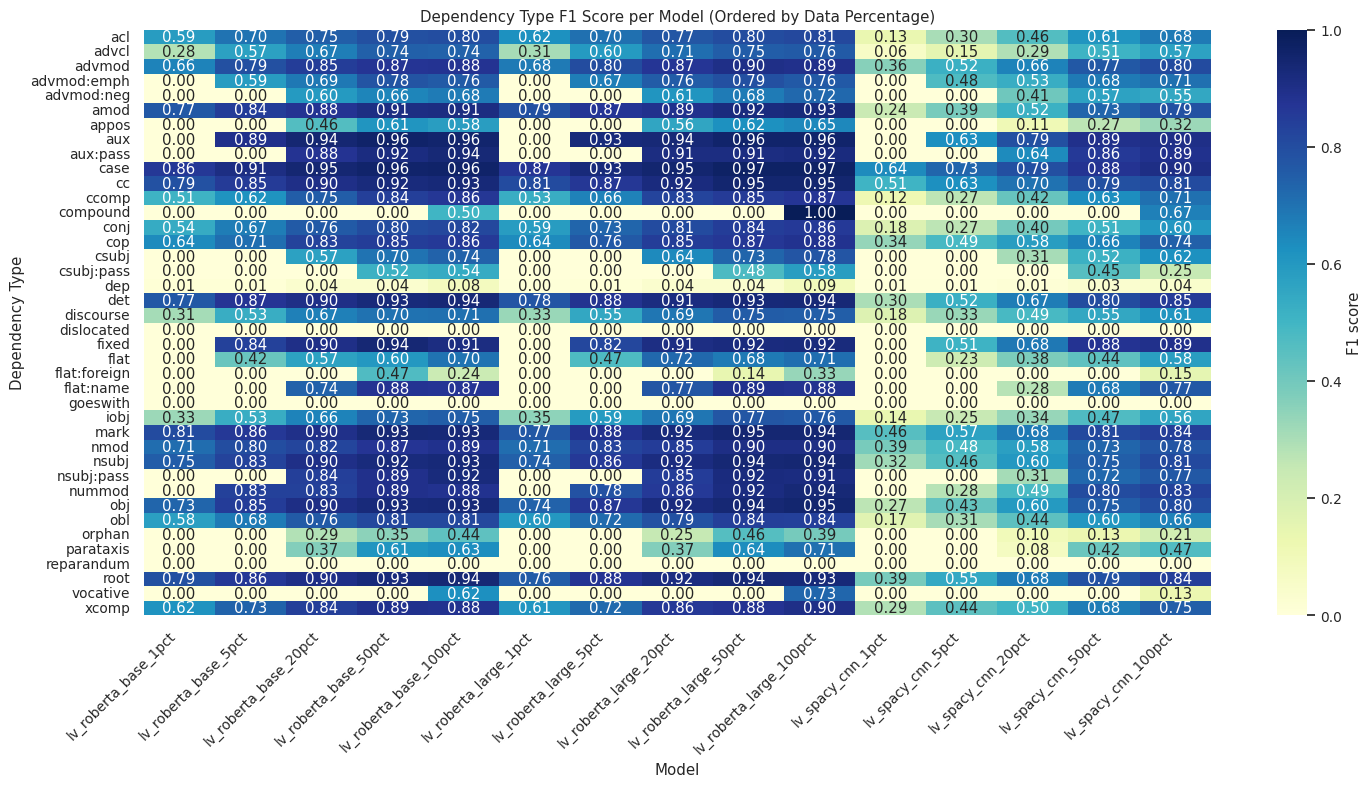

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# 1. 读 CSV
csv_path = './Summary_CSVs/evaluation_dep_las_per_type.csv'
df = pd.read_csv(csv_path)

# 2. Pivot 表格
heatmap_data = df.pivot(index='dep_type', columns='model', values='f')

# 3. 自动按模型名和数据百分比排序
def model_sort_key(model_name):
    # 例子：'lv_spacy_cnn_1pct' -> ('lv_spacy_cnn', 1)
    match = re.match(r'(.+?)_(\d+)pct', model_name)
    if match:
        base, pct = match.groups()
        return (base, int(pct))
    else:
        return (model_name, 0)

sorted_columns = sorted(heatmap_data.columns, key=model_sort_key)
heatmap_data = heatmap_data[sorted_columns]

# 4. 绘图
plt.figure(figsize=(15, 8))
sns.set(font_scale=0.9)
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'F1 score'}
)

plt.title("Dependency Type F1 Score per Model (Ordered by Data Percentage)")
plt.ylabel("Dependency Type")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


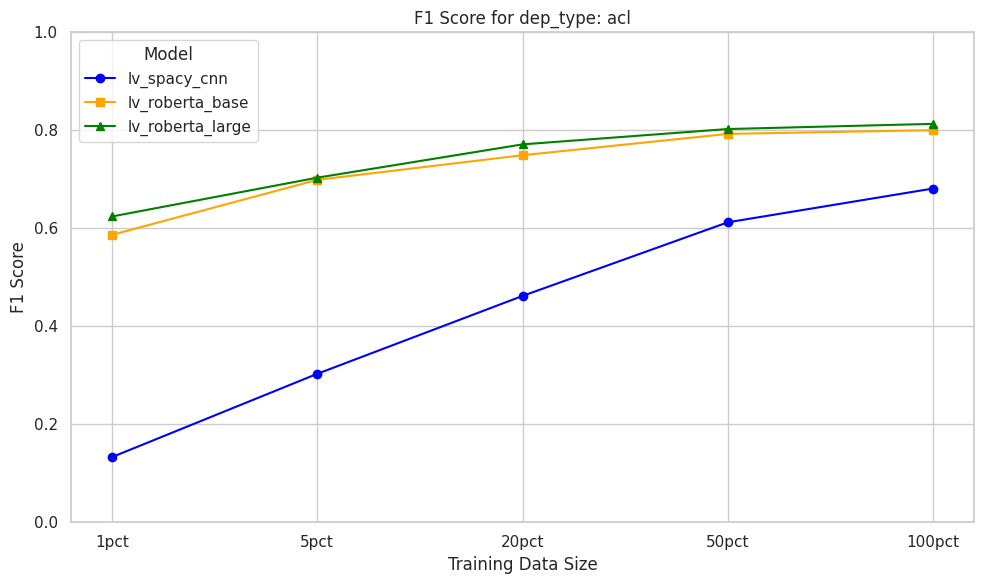

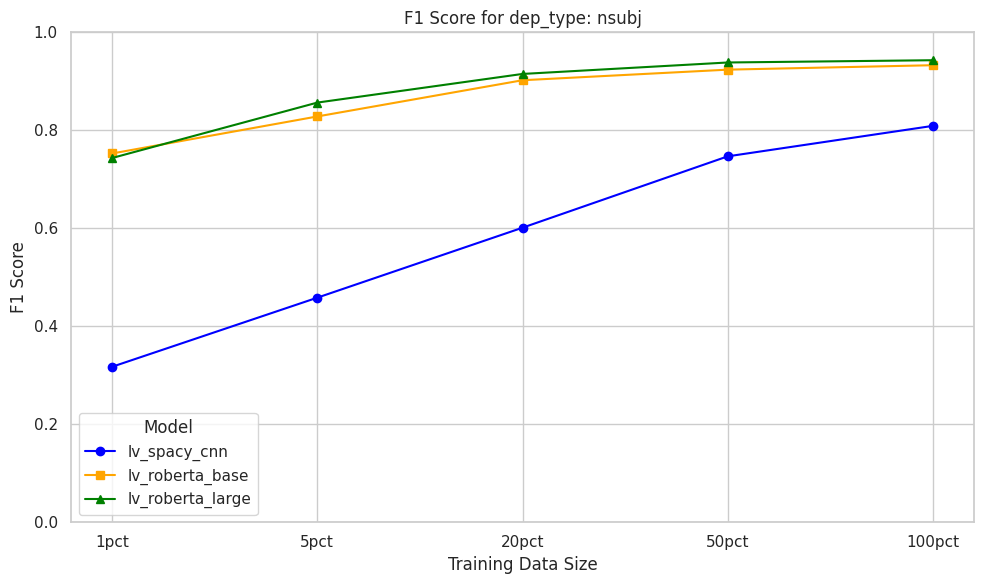

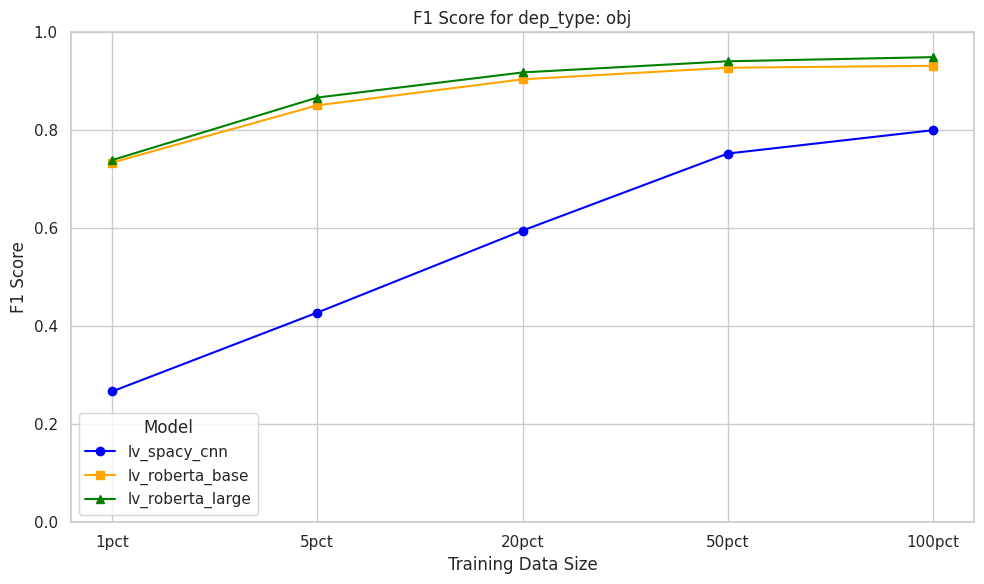

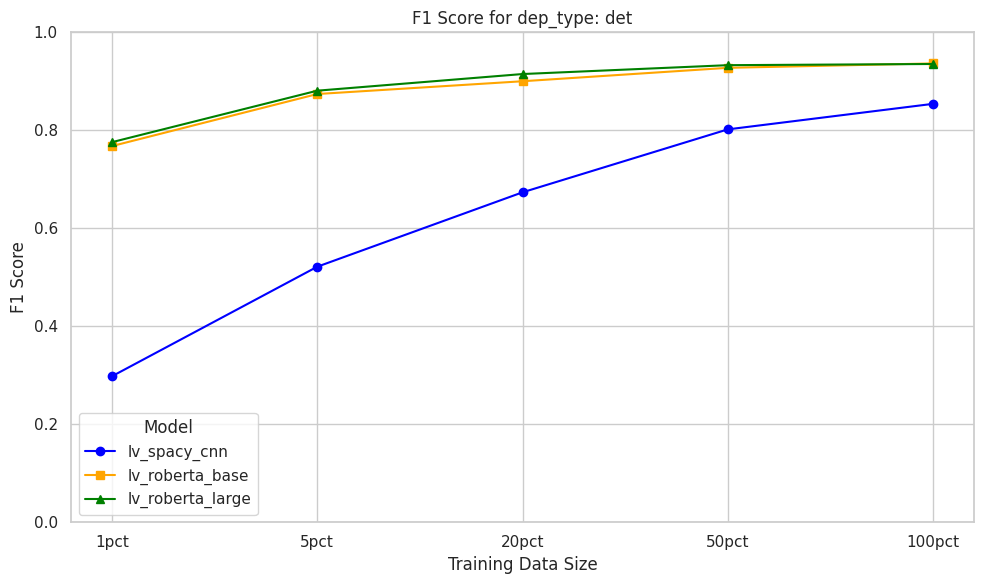

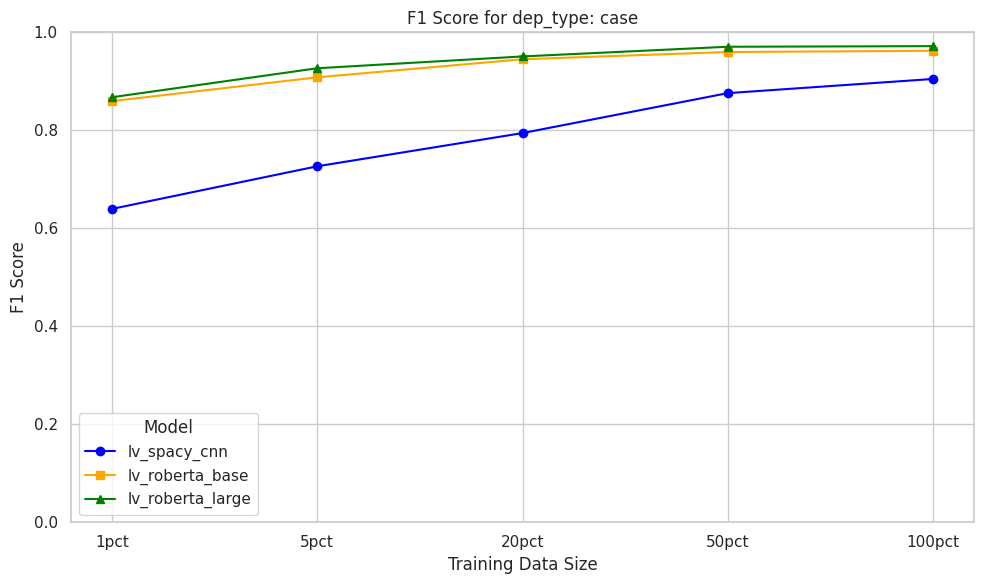

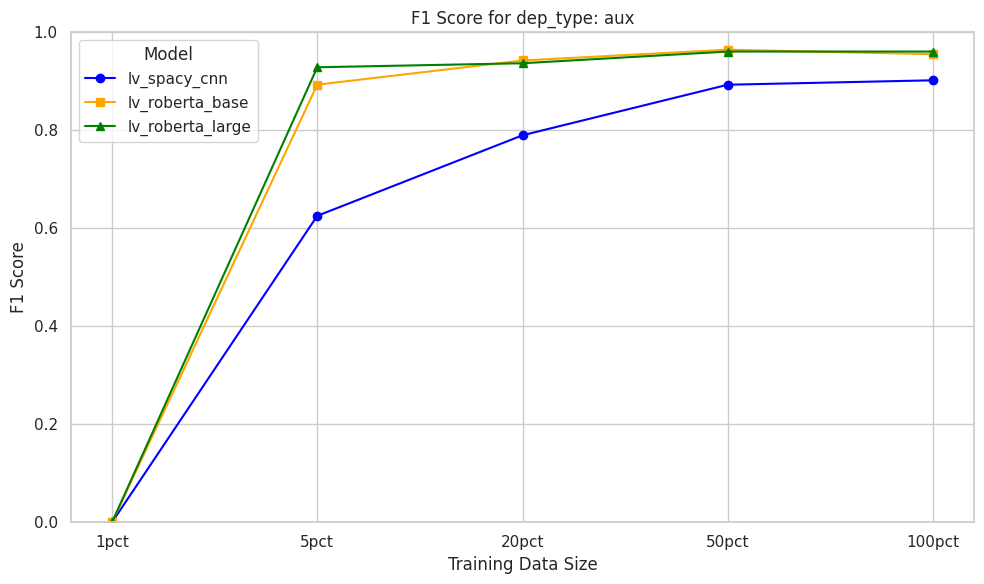

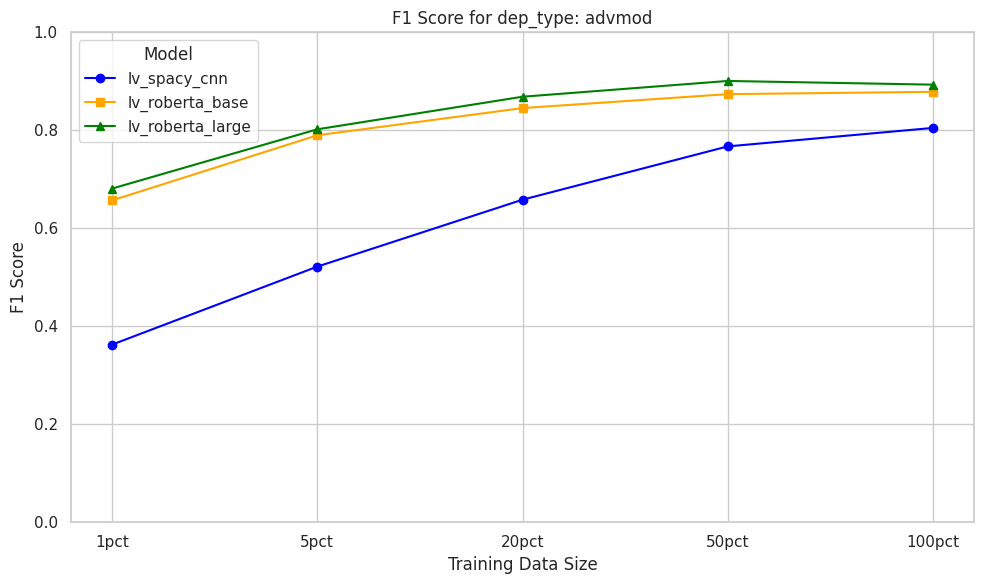

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 加载 CSV
df = pd.read_csv("./Summary_CSVs/evaluation_dep_las_per_type.csv")

# 提取训练比例和模型名
df['train_pct'] = df['model'].apply(lambda x: x.split('_')[-1])
df['model_name'] = df['model'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# 设置绘图风格
sns.set(style="whitegrid")

# 定义 3 个模型的颜色和 marker
model_styles = {
    'lv_spacy_cnn':      {'color': 'blue',   'marker': 'o', 'linestyle': '-'},
    'lv_roberta_base':   {'color': 'orange', 'marker': 's', 'linestyle': '-'},
    'lv_roberta_large':  {'color': 'green',  'marker': '^', 'linestyle': '-'}
}

# 选择 dep_type
dep_types = ['acl', 'nsubj', 'obj', 'det', 'case', 'aux', 'advmod']

# 画图
for dep in dep_types:
    plt.figure(figsize=(10,6))
    subset = df[df['dep_type'] == dep]

    for model_name, style in model_styles.items():
        sub_model = subset[subset['model_name'] == model_name]
        # 按训练比例排序
        sub_model = sub_model.set_index('train_pct').reindex(['1pct','5pct','20pct','50pct','100pct']).reset_index()

        plt.plot(sub_model['train_pct'], sub_model['f'],
                 marker=style['marker'],
                 linestyle=style['linestyle'],
                 color=style['color'],
                 label=model_name)

    plt.title(f"F1 Score for dep_type: {dep}")
    plt.xlabel("Training Data Size")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=0)
    plt.ylim(0,1)  # F1 范围
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
